# Seedling classification

Downloaded from https://www.kaggle.com/c/plant-seedlings-classification/data

In [2]:
!unzip train.zip
!unzip test.zip
!unzip sample_submission.csv.zip

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [3]:
!ls -la

total 1766584
drwxr-xr-x  6 1000 1000       4096 Feb 25 22:41 .
drwxr-xr-x 48 root root       4096 Feb 25 22:37 ..
drwxrwxr-x  3 1000 1000       4096 Feb 25 22:37 .idea
drwxr-xr-x  2 root root       4096 Feb 25 22:38 .ipynb_checkpoints
-rw-r--r--  1 1000 1000        129 Feb 25 22:37 docker-compose.yaml
-rw-rw-r--  1 root root      19863 Nov 21 19:37 sample_submission.csv
-rw-rw-r--  1 1000 1000       5251 Feb 25 22:08 sample_submission.csv.zip
-rw-r--r--  1 root root     191378 Feb 25 22:39 seedlings_classifier.ipynb
drwxrwxr-x  2 root root      32768 Nov 21 19:27 test
-rw-rw-r--  1 1000 1000   90141460 Feb 25 22:09 test.zip
drwxrwxr-x 14 root root       4096 Nov 21 19:11 train
-rw-rw-r--  1 1000 1000 1718530069 Feb 25 22:18 train.zip


In [5]:
!head sample_submission.csv

file,species
0021e90e4.png,Sugar beet
003d61042.png,Sugar beet
007b3da8b.png,Sugar beet
0086a6340.png,Sugar beet
00c47e980.png,Sugar beet
00d090cde.png,Sugar beet
00ef713a8.png,Sugar beet
01291174f.png,Sugar beet
026716f9b.png,Sugar beet


### Dependencies

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
import os

In [2]:
train_pth = "train/"

### Load categories

In [3]:
categories = []
for i in glob(os.path.join(train_pth, "*")):
    categories.append(i.replace(train_pth, ""))

In [4]:
categories

['Loose Silky-bent',
 'Scentless Mayweed',
 'Fat Hen',
 'Small-flowered Cranesbill',
 'Common Chickweed',
 'Common wheat',
 'Black-grass',
 'Sugar beet',
 'Shepherds Purse',
 'Maize',
 'Charlock',
 'Cleavers']

In [84]:
train = []
category_counter = {c: 0 for c in categories}
for c in categories:
    for i in glob(os.path.join(train_pth, c, "*")):
        category_counter[c] += 1
        train.append((i, c))

In [85]:
category_counter

{'Black-grass': 263,
 'Charlock': 390,
 'Cleavers': 287,
 'Common Chickweed': 611,
 'Common wheat': 221,
 'Fat Hen': 475,
 'Loose Silky-bent': 654,
 'Maize': 221,
 'Scentless Mayweed': 516,
 'Shepherds Purse': 231,
 'Small-flowered Cranesbill': 496,
 'Sugar beet': 385}

In [86]:
len(train)

4750

In [87]:
train[:10]

[('train/Loose Silky-bent/b81690ccf.png', 'Loose Silky-bent'),
 ('train/Loose Silky-bent/8fab11dfb.png', 'Loose Silky-bent'),
 ('train/Loose Silky-bent/4c800c3db.png', 'Loose Silky-bent'),
 ('train/Loose Silky-bent/943edde10.png', 'Loose Silky-bent'),
 ('train/Loose Silky-bent/5ca0fcfba.png', 'Loose Silky-bent'),
 ('train/Loose Silky-bent/7b4598d18.png', 'Loose Silky-bent'),
 ('train/Loose Silky-bent/5bd4637e1.png', 'Loose Silky-bent'),
 ('train/Loose Silky-bent/06bbb09fb.png', 'Loose Silky-bent'),
 ('train/Loose Silky-bent/980937153.png', 'Loose Silky-bent'),
 ('train/Loose Silky-bent/730b45269.png', 'Loose Silky-bent')]

<Container object of 12 artists>

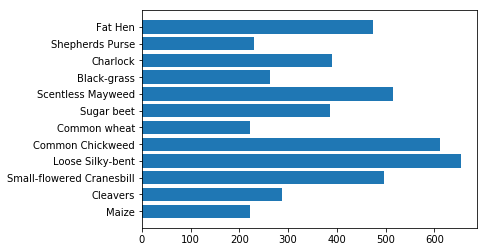

In [88]:
plt.barh(range(len(category_counter)), category_counter.values(), tick_label=category_counter.keys())

## Look on samples

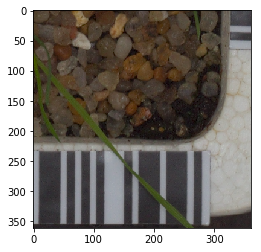

In [92]:
from PIL import Image
plt.imshow(Image.open(train[1][0]))

## Extract features

In [158]:
import tensorflow as tf
import numpy as np

In [159]:
tf.__version__

'1.5.0'

In [166]:
ResNet50 = tf.keras.applications.ResNet50
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [167]:
resnet_model = ResNet50(weights='imagenet', include_top=False)

In [168]:
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return resnet_model.predict(x)[0][0][0]

In [169]:
f = extract_features(train[0][0])
print(f[:5])
print(len(f))

[0.         0.01295449 1.3194734  0.50039893 0.        ]
2048


In [109]:
train_features = []
for i in train:
    train_features.append((extract_features(i[0]), i[1]))

In [110]:
print(train_features[:2])
print(len(train_features), len(train))

[(array([0.        , 0.01295449, 1.3194734 , ..., 0.        , 0.        ,
       0.        ], dtype=float32), 'Loose Silky-bent'), (array([0.3459072 , 0.08875558, 4.0197587 , ..., 1.1675652 , 0.28601465,
       0.75289005], dtype=float32), 'Loose Silky-bent')]
(4750, 4750)


In [111]:
import pickle

In [112]:
#pickle.dump(train_features, open("train_features.pkl", "wb"))
train_features = pickle.load(open("train_features.pkl", "rb"))

## Train test split

In [115]:
from sklearn.model_selection import train_test_split

In [116]:
x = [i[0] for i in train_features]
y = [i[1] for i in train_features]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

## Train model

In [170]:
Sequential = tf.keras.models.Sequential
Dense = tf.keras.layers.Dense
Activation = tf.keras.layers.Activation

In [171]:
model = Sequential([
    Dense(2048, input_shape=(2048,)),
    Activation('relu'),
    Dense(12),
    Activation('softmax'),
])

In [172]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [173]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
one_hot_labels = keras.utils.to_categorical(le.fit_transform(y_train), num_classes=12)
model.fit(np.array(x_train), one_hot_labels, epochs=10, batch_size=32)

Epoch 1/10
3800/3800 [==============================]3800/3800 [==============================] - 23s 6ms/step - loss: 1.6413 - acc: 0.6939

Epoch 2/10
3800/3800 [==============================]3800/3800 [==============================] - 18s 5ms/step - loss: 0.8525 - acc: 0.8505

Epoch 3/10
3800/3800 [==============================]3800/3800 [==============================] - 19s 5ms/step - loss: 0.2602 - acc: 0.9084

Epoch 4/10
3800/3800 [==============================]3800/3800 [==============================] - 20s 5ms/step - loss: 0.1723 - acc: 0.9432

Epoch 5/10
3800/3800 [==============================]3800/3800 [==============================] - 19s 5ms/step - loss: 0.1238 - acc: 0.9576

Epoch 6/10
3800/3800 [==============================]3800/3800 [==============================] - 19s 5ms/step - loss: 0.1009 - acc: 0.9674

Epoch 7/10
3800/3800 [==============================]3800/3800 [==============================] - 19s 5ms/step - loss: 0.0801 - acc: 0.9745

Epoch 8/10
38

## Eval

In [174]:
test_one_hot_labels = keras.utils.to_categorical(le.transform(y_test), num_classes=12)
model.evaluate(np.array(x_test), test_one_hot_labels, batch_size=128)

950/950 [==============================]950/950 [==============================] - 2s 2ms/step



[0.3157145043423301, 0.9115789477448715]

## Submit

In [186]:
from __future__ import print_function
test_samples = len(glob("test/*"))
processed = 0

with open("submission.csv", "w") as w:
    w.write("file,species\n")
    for i in glob("test/*"):
        f = extract_features(i)
        p = model.predict_classes(np.array([f]))
        name = i.replace("test/", "")
        w.write("{},{}\n".format(name, le.classes_[p][0]))
        processed += 1
        print("\r{}/{}".format(processed, test_samples), end="")

794/794

In [187]:
!head submission.csv

file,species
a35fd6fbb.png,Common Chickweed
6049234e6.png,Fat Hen
bd72d4d8a.png,Scentless Mayweed
8a4d3a1b1.png,Loose Silky-bent
599c82eea.png,Scentless Mayweed
c7b07431e.png,Scentless Mayweed
976e4e079.png,Common Chickweed
93079d970.png,Sugar beet
04814f36d.png,Scentless Mayweed
